In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randn

%matplotlib inline

# SA(2) invariant signatures
We are considering transformations in $SA(2)$ of the following form:

\begin{equation}
   \hat{x}_i = a_{ij} x_j + b_i
\end{equation}

where $\det a = 1$, or in vector notation $\hat{x} = Ax + b$, $\det A = 1$. Our image $f : \mathbb{R}^2 \mapsto \mathbb{R}$ transforms as $f(x) = \hat{f}(\hat{x})$. Then, we have the following:

\begin{align}
    f_{,i} &= \hat{f}_{,k}a_{ki}, & \nabla{f} &= A^T \nabla{\hat{f}} \\
    f_{,ij} &= \hat{f}_{,kl} a_{ki} a_{lj} & \nabla^2 f &= A^T \nabla^2 \hat{f} A
\end{align}

We can see that in vector notation, we have the following invariants under SA(2) (at $x$ on the left and $\hat{x}$ on the right:
1. $I_0 = f(x) = \hat{f}(\hat{x})$
2. $I_1 = \det \nabla^2 f(x) = \det(A^T)\det \nabla^2 \hat{f} \det(A) = \det \nabla^2 \hat{f}$
3. $I_2 =(\nabla f)^T (\nabla^2 f)^{-1} (\nabla f) = (\nabla \hat{f})^T A A^{-1} (\nabla^2 \hat{f})^{-1} A^{-T} A^T \nabla{\hat f} = (\nabla \hat{f})^T (\nabla^2 \hat{f})^{-1} \nabla \hat{f}$

The third invariant is in fact invariant under $A(2)$, not just $SA(2)$. However, for $SA(2)$ we can replace it with a polynomial by multiplying by $\det \nabla^2 f$, in which case $(\nabla^2 f)^{-1}$ is replaced by $\text{adj} \nabla^2 f$.

3a. $I_2 = (\nabla f)^T \text{adj} \nabla^2 f \nabla f = f_{yy} f_x^2 - 2f_{xy}f_x f_y + f_{xx} f_y^2 $

In [3]:
def SA2signature(F, h=1):
    """ Compute equiaffine-invariant image signature using finite differences"""
    Fx, Fy = np.gradient(F, h)
    Fxx, Fxy = np.gradient(Fx, h)
    Fyx, Fyy = np.gradient(Fy, h)
    
    I0 = F # function value
    I1 = Fxx*Fyy - Fxy*Fyx # determinant
    I2 = Fyy*Fx*Fx - 2*Fxy*Fx*Fy + Fxx*Fy*Fy 

    return (I0, I1, I2)

## Test image
We use as our test function the function `f(x, y)` defined below

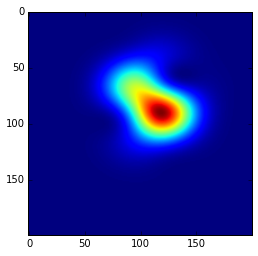

In [16]:
def f(x, y):
    return 0.5*(1 + np.sin(4*x) * np.cos(7*y)) * 2*np.exp(-10*((x - 0.1)**2 + (y+0.2)**2))

h = 0.01
X, Y = np.meshgrid(np.arange(-1, 1, h), np.arange(-1, 1, h))
F0 = f(X, Y)
plt.imshow(F0)

## Transformation
We generate a random equiaffine transformation $x \mapsto Ax + b$, $\det A = 1$ as follows:


In [36]:
from numpy.random import rand, randn

A = np.random.randn(2,2)
if np.linalg.det(A) < 0:
    A[:, 1] = -A[:, 1]
A = A / np.sqrt(np.linalg.det(A))
b = 0.2 * randn(2)
Ainv = np.linalg.inv(A)
binv = -np.linalg.solve(A, b)


The image and its transformation are plotted below


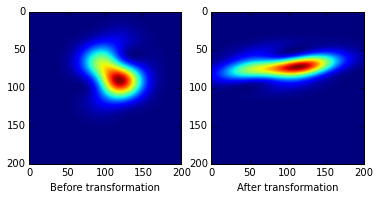

In [37]:
F1 = f(Ainv[0,0]*X + Ainv[0,1]*Y + binv[0], Ainv[1,0]*X + Ainv[1,1]*Y + binv[1])

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(F0)
axarr[0].set_xlabel('Before transformation')
axarr[1].imshow(F1)
axarr[1].set_xlabel('After transformation')

## Compare signatures of the two images
We compare the signatures for a few contours (with respect to the function value)


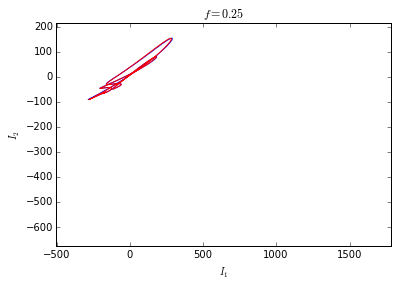

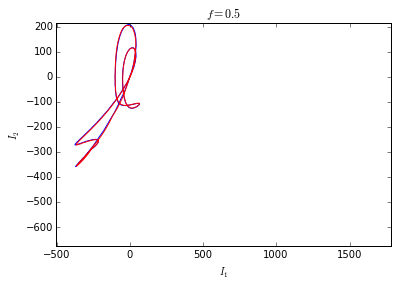

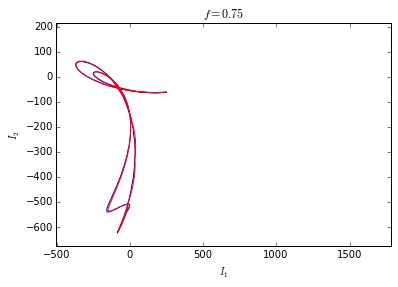

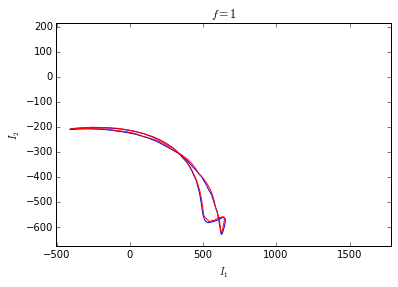

In [38]:
sig0 = SA2signature(F0, h)
sig1 = SA2signature(F1, h)
contour_levels = [0.25, 0.5, 0.75, 1]

for level in contour_levels:
    plt.figure()
    plt.contour(sig0[1], sig0[2], sig0[0], levels=[level], colors='blue')
    plt.contour(sig1[1], sig1[2], sig1[0], levels=[level], colors='red')
    plt.xlabel('$I_1$')
    plt.ylabel('$I_2$')
    plt.title('$f = {}$'.format(level))
